Repeating the crit chart from EU

In [24]:
# Crit chart
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme()
sns.set(context="paper", style="darkgrid", font="Calibri", font_scale = 2.2)


data_adp = "ADP_expanded.xlsx"
df_adp = pd.read_excel(data_adp, engine="openpyxl", sheet_name="CritMats")
df_adp= df_adp[['Symbol','Supply Risk', 'EI']]

df_adp["Criticality"] = "Non Critical"
df_adp["lenn"] = 2

for idx, row in df_adp.iterrows():
    if row["Supply Risk"]>=1 and row["EI"]>=2.8:
        df_adp.at[idx,"Criticality"] = "Critical"
    df_adp.at[idx,"lenn"] = len(row["Symbol"])

df_adp = df_adp[df_adp["lenn"]<=2]

df_adp.reset_index(inplace=True)
df_adp


,index,Symbol,Supply Risk,EI,Criticality,lenn
0,0,Ce,6.2,3.5,Critical,2
1,1,Dy,6.2,7.2,Critical,2
2,2,Er,6.1,3.1,Critical,2
3,3,Gd,6.1,4.6,Critical,2
4,4,Ho,6.1,3.4,Critical,2
...,...,...,...,...,...,...
56,76,Cu,0.3,5.3,Non Critical,2
57,77,S,0.3,4.1,Non Critical,1
58,78,Zn,0.3,5.4,Non Critical,2
59,80,Au,0.2,2.1,Non Critical,2


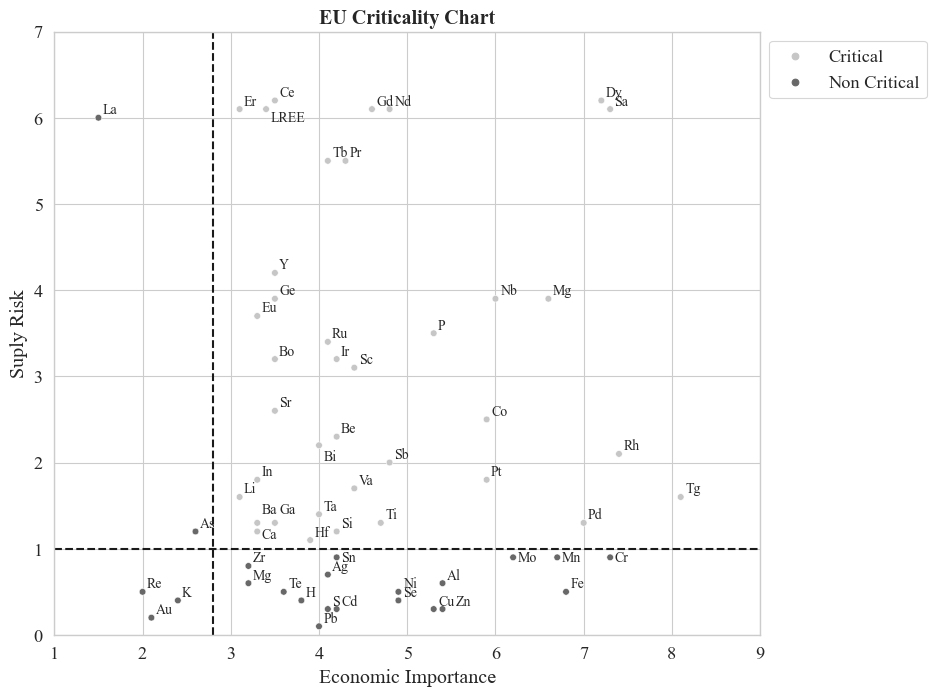

In [25]:
cm =0.6
sns.set_theme()
sns.set(context="paper", style="whitegrid", font="Times New Roman", font_scale = 1.5)
fig, axs = plt.subplots(1,1, figsize=(16*cm,12*cm))
axs.set_title("EU Criticality Chart", fontweight='bold')
marks = ["x" if d == "Critical" else "o" for d in df_adp['Supply Risk']]
sns.scatterplot(data=df_adp, y='Supply Risk', x="EI", hue="Criticality" , ax=axs, 
                #s=25,
                  palette="Greys", markers = marks )
axs.plot([0, 9], [1, 1], "k--",linewidth=1.5)  #horizontal line
axs.plot([2.8, 2.8], [0, 9], "k--",linewidth=1.5) #vertical
axs.set_ylim(0,7)
axs.set_xlim(1,9)
axs.set_xlabel("Economic Importance")
axs.set_ylabel("Suply Risk")
axs.legend(loc="upper left", bbox_to_anchor=(1,1))

#axs.set_yscale("log")
#axs.set_xscale("log")
points = []
for i, label in enumerate (df_adp["Symbol"]):
    x = df_adp["EI"][i]+0.05
    y = df_adp["Supply Risk"][i]+0.05
    if label == "Ho":
        label = "LREE"
        y*=0.97
    if label in ["Ba", "Ga"]:
        y*=1.05
    if label in ["Ca", "Bi"]:
        y*=0.9
    if label in ["Zn"]:
        x+=0.1
    if label in ["Sn","Mo","Mn", "Cr"]:
        y-=0.1
    axs.annotate(label, (x, y), fontsize = 10)
plt.tight_layout()    

plt.savefig("crit_chart_bw.png", dpi=600)

In [26]:
MIN_SR = min(df_adp["Supply Risk"])
MIN_EI = min(df_adp["EI"])
MIN_GPR = min(df_adp["SR/Prod"])
from sql_connect import create_connection
import numpy as np

def get_ps_impacts(CAT):
    #fetch the results of the sql DB
    DB_CORR = "dbs\TEMPRO_DB220519_Corr_no_recycling.db"
    conn = create_connection(DB_CORR)

    queryLCA = f'SELECT * FROM [{CAT}LCAResults]'
    lca = pd.read_sql_query(queryLCA, conn)

    tables={2000:"2000Parts", 3000:"3000Pieces", 4000:"4000Devices"}

    queryPS = f'SELECT * FROM [{tables[CAT]}]'

    ps_list = pd.read_sql_query(queryPS, conn)
    ps_list.set_index("ID", inplace=True)

    df_subsubcats = pd.read_excel(
            "2000subsubcats1.xlsx", engine="openpyxl", sheet_name="Subsubcat")
    df_subsubcats.set_index("ID", inplace=True)
    ps_list= ps_list[["Name", "Amount"]]


    ps_list["Subcat"] = np.nan
    ps_list["ADP"] = np.nan
    ps_list["ADP-SR"] = np.nan
    ps_list["ADP-EI"] = np.nan
    ps_list["GPR"] = np.nan
    ps_list["CED"] = np.nan
    for idx in ps_list.index:
        lca_ps = lca[lca["ProductSystemID"]==idx]
        lca_ps.set_index("Category", inplace=True)
        amount = ps_list.at[idx,"Amount"]
        try:
            ps_list.at[idx,"ADP"]=lca_ps.at["ADP-Minerals- Total", "Result"]/amount
            ps_list.at[idx,"ADP-SR"] = lca_ps.at["SR-Minerals- Total", "Result"]/amount
            ps_list.at[idx,"ADP-EI"] =lca_ps.at["EI-Minerals- Total", "Result"]/amount
            ps_list.at[idx,"GPR"] = lca_ps.at["GPR-Minerals- Total", "Result"]/amount
            ps_list.at[idx,"CED"] = lca_ps.at["CED - total", "Result"]/amount
            ps_list.at[idx,"RawMat"] = lca_ps.at["EDIP", "Result"]/amount
            ps_list.at[idx, "Subcat"] = df_subsubcats.at[idx, "Subsubcat New"]
        except:
            pass
    ps_list=ps_list[ps_list["Subcat"]!="Energy"]
    ps_list=ps_list[ps_list["ADP"]>0]
    ps_list["SR_eq"] = ps_list["ADP-SR"]/ps_list["ADP"]*MIN_SR
    ps_list["EI_eq"] = ps_list["ADP-EI"]/ps_list["ADP"]*MIN_EI
    ps_list["GPR_eq"] = ps_list["GPR"]/ps_list["RawMat"]#*MIN_GPR
    ps_list.to_csv(f"ps_eval{CAT}.csv")
    return ps_list
    

KeyError: 'SR/Prod'

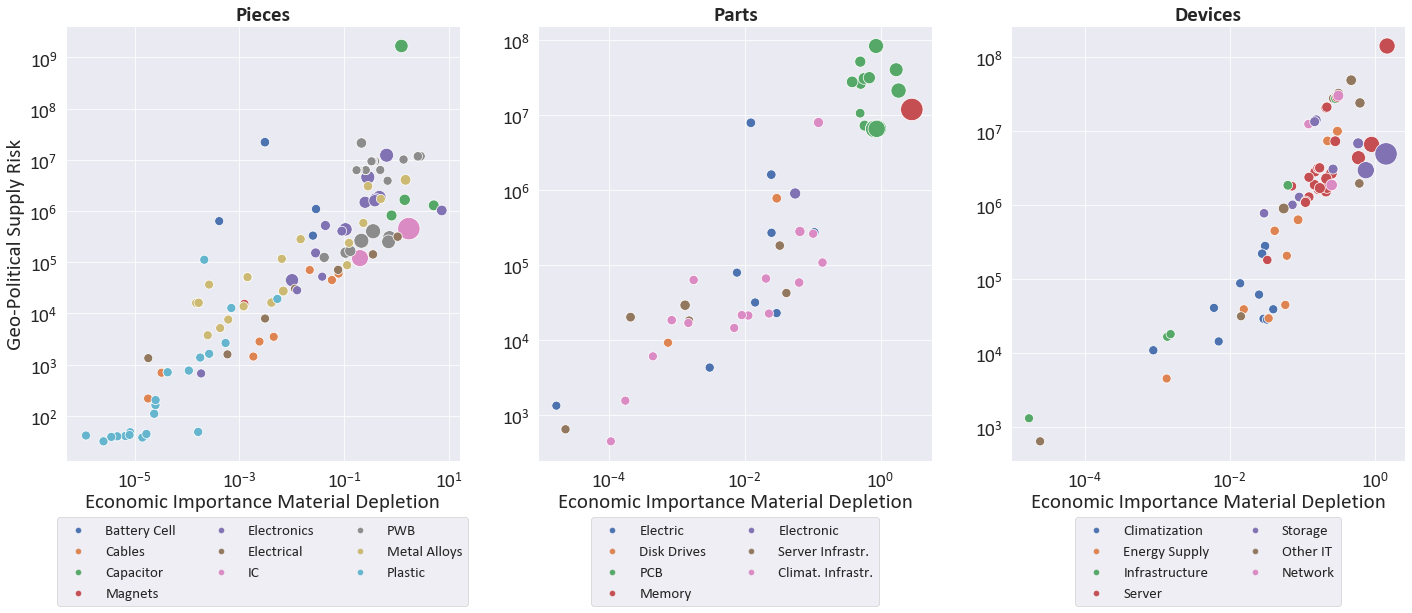

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24,8))
i = 0
for CAT in [2000, 3000, 4000]:
    ps_list = get_ps_impacts(CAT)
    ax = axs[i]
    num_elem = {0: 11, 1: 8, 2: 8}
    num_col = {0: 3, 1: 2, 2: 2}
    titles={0: "Pieces", 1: "Parts", 2: "Devices"}
    sns.scatterplot(data=ps_list, x="ADP-EI", y="GPR",
                    hue="Subcat", size="CED", sizes=(80, 500), ax=ax, alpha=1)
    ax.set_yscale('log')
    ax.set_xscale('log')

    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.legend(handles[1:num_elem[i]], labels[1:num_elem[i]],
              loc='lower center',
              bbox_to_anchor=(0.5, -0.35), ncol=num_col[i],
              fontsize=15)
    ax.set_ylabel("Geo-Political Supply Risk")
    ax.set_xlabel("Economic Importance Material Depletion")
    if i!=0:
        ax.set_ylabel("")

    ax.set_title(titles[i],fontweight='bold')
    i += 1
    #ax.legend(bbox_to_anchor=(0, 0), loc="lower center", borderaxespad=0)
fig.savefig("DataExploration/PS_Impcats.png",bbox_inches='tight')

#plt.plot([0, 9], [1, 1], "g--",linewidth=1)
#plt.plot([2.8, 2.8], [0, 4], "g--",linewidth=1)
